In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import warnings
import itertools
import os
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

/Users/ali.kishk/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Find the percentage of each phenotype in each pathway
def Calculate_Enrichment_Coverage(enrich,sko_summ,target_col):
    enrich_coverage = enrich
    phenotypes =  sko_summ.index 
    for j in range(sko_summ.shape[0]):
        enrich_coverage[phenotypes[j]] = np.zeros((enrich.shape[0],1))
        query_genes = sko_summ.loc[phenotypes[j],target_col]
        query_genes = query_genes.split('; ')# for x in query_genes]
        #query_genes  =np.unique(np.concatenate(query_genes))
        query_genes = [x for x in query_genes if x not in ['NaN','nan']]
        for i in range(enrich.shape[0]):
            enrich_genes = enrich.Genes[i].split(';')
            shared_genes = [x for x in query_genes if x in enrich_genes]
            total_path_genes = int(enrich.Overlap[i].split('/')[1])
            enrich_coverage[phenotypes[j]][i] = len(shared_genes)/total_path_genes#len(enrich_genes)
            enrich_coverage.index = enrich_coverage.Term
    return enrich_coverage

In [7]:
from gseapy.parser import Biomart

bm = Biomart(verbose=False, host="asia.ensembl.org")
## view validated marts
marts = bm.get_marts()
## view validated dataset
datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
## view validated attributes
attrs = bm.get_attributes(dataset='hsapiens_gene_ensembl')
## view validated filters
filters = bm.get_filters(dataset='hsapiens_gene_ensembl')

In [8]:
import pickle
with open(r"SKO_genes_per_study.pkl", "rb") as input_file:
    SKO_per_study = pickle.load(input_file)

In [11]:
sko_gtex_drugs = pd.read_csv('Drug_Repurposing_Results_/SKO_GTEx_Drugs.csv',index_col=0)
sko_gtex_drugs = sko_gtex_drugs.reset_index(drop=True)
druggable_sko_genes = sko_gtex_drugs.Gene_Symbol.tolist()

In [12]:
sko_gtex_drugs

,Gene_Symbol,Drugs,Drugs_Action,GTEx_Safety_Class,Phenotype_Safety,Phenotype_Essentiality,GTEx_Safety,Drugs_Group,Gene_Categories,ATC_Code,Gene_Categories.1,Drugs_Categories,side_effect_name,Meddra_Indication
0,GUK1,Acyclovir,substrate,Toxic,2,4,10,approved|investigational,enzyme,J05AB11,enzyme,"Acyclovir and prodrug|Amino Acids|Amino Acids,...",NaN,"['Congenital herpes simplex infection', 'Derma..."
1,GUK1,Guanosine-5'-Monophosphate,substrate,Toxic,2,4,10,approved,enzyme,J05AB01|D06BB03|S01AD03|D06BB53,enzyme,Acyclovir and prodrug|Anti-Infective Agents|An...,NaN,"['Acquired immunodeficiency syndrome', 'Autoim..."
2,GUK1,Valaciclovir,NaN,Toxic,2,4,10,experimental,target,NaN,target,NaN,NaN,NaN
3,CTH,2-[(3-Hydroxy-2-Methyl-5-Phosphonooxymethyl-Py...,cofactor,UNK,1,3,18,approved|investigational|nutraceutical,target,A11HA06,target,Alimentary Tract and Metabolism|Coenzymes|Diet...,NaN,NaN
4,CTH,Cysteine,NaN,UNK,1,3,18,approved|nutraceutical,target,NaN,target,"Amino Acids|Amino Acids, Neutral|Amino Acids, ...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,DTYMK,P1-(5'-Adenosyl)P5-(5'-(3'azido-3'-Deoxythymid...,NaN,Safe,7,0,20,experimental,target,NaN,target,Carbohydrates|Deoxyribonucleosides|Deoxyribonu...,NaN,NaN
57,DTYMK,3'-deoxy-3'-aminothymidine monophosphate,NaN,Safe,7,0,20,experimental,target,NaN,target,NaN,NaN,NaN
58,DTYMK,Phosphoaminophosphonic Acid-Adenylate Ester,NaN,Safe,7,0,20,experimental,target,NaN,target,NaN,NaN,NaN
59,SLC7A9,Cystine,substrate,Partial_Toxic,7,0,18,approved|investigational|nutraceutical,transporter,A16AA03,transporter,Alimentary Tract and Metabolism|Amino Acids|Am...,NaN,NaN


### Ferroptosis Relationship using FerrDb 
#### https://academic.oup.com/database/article/doi/10.1093/database/baaa021/5812716

In [13]:
# 3 classes for genes ['Driver','Suppressor','Marker']
ferrdb_1 = pd.read_csv('ferrdb/1_info_suppressor.csv')
ferrdb_1['Relationship'] = 'Suppressor' 
ferrdb_2 = pd.read_csv('ferrdb/1_info_driver.csv')
ferrdb_2['Relationship'] = 'Driver' 
ferrdb_3 = pd.read_csv('ferrdb/1_info_marker.csv')
ferrdb_3['Relationship'] = 'Marker' 
ferrdb = pd.concat([ferrdb_1,ferrdb_2,ferrdb_3])

In [14]:
ferrdb.shape

(382, 15)

In [15]:
# Shared genes between ferrdb and all SKO targets
sko_gtex = pd.read_csv('SKO_ALL_Studies.csv',index_col=0)

#sko_gtex_drugs= sko_gtex_drugs.reset_index()
sko_genes = sko_gtex.index.tolist()
ferrdb_genes = ferrdb.Symbol.tolist()
shared_genes = np.unique([gene for gene in sko_genes if gene in ferrdb_genes])
shared_genes

array(['SLC3A2', 'SLC7A11', 'SLC7A5'], dtype='<U7')

In [16]:
sko_gtex.columns = ['Genes','Gene_Symbol','Phenotype_Essentiality']

ValueError: Length mismatch: Expected axis has 4 elements, new values have 3 elements

In [17]:
shared_genes_evidence = ferrdb.loc[ferrdb.Symbol.isin(shared_genes),:]
shared_genes_evidence.to_csv('Drug_Repurposing_Results_/SKO_in_Ferrdb_Evidence.csv')
shared_genes_evidence = shared_genes_evidence.loc[:,['Symbol','Relationship']].drop_duplicates(subset=['Symbol'])
shared_genes_evidence

,Symbol,Relationship
0,SLC7A11,Suppressor
19,SLC3A2,Suppressor
30,SLC7A5,Marker


In [18]:
ferrdb_genes = ferrdb.Symbol.unique().tolist()
shared_genes = np.unique([gene for gene in druggable_sko_genes if gene in ferrdb_genes])
shared_genes

array(['SLC7A11', 'SLC7A5'], dtype='<U7')

In [19]:
shared_genes_evidence = ferrdb.loc[ferrdb.Symbol.isin(shared_genes),:]
shared_genes_evidence.to_csv('Drug_Repurposing_Results/Druggable_SKO_in_Ferrdb_Evidence.csv')
shared_genes_evidence = shared_genes_evidence.loc[:,['Symbol','Relationship']].drop_duplicates(subset=['Symbol'])
shared_genes_evidence

,Symbol,Relationship
0,SLC7A11,Suppressor
30,SLC7A5,Marker


In [20]:
shared_genes_drugs = sko_gtex_drugs.loc[sko_gtex_drugs.Gene_Symbol.isin(shared_genes),:]
shared_genes_drugs['ferrdb_classification'] = 0
for gene in shared_genes:
    ferrdb_classification = shared_genes_evidence.loc[shared_genes_evidence.Symbol==gene,'Relationship'].values
    shared_genes_drugs.loc[shared_genes_drugs.Gene_Symbol==gene,'ferrdb_classification'] = [ferrdb_classification[0]]*sum(shared_genes_drugs.Gene_Symbol==gene)
shared_genes_drugs.to_csv('Drug_Repurposing_Results_/SKO_in_Ferrdb_Drugs.csv')
shared_genes_drugs

,Gene_Symbol,Drugs,Drugs_Action,GTEx_Safety_Class,Phenotype_Safety,Phenotype_Essentiality,GTEx_Safety,Drugs_Group,Gene_Categories,ATC_Code,Gene_Categories.1,Drugs_Categories,side_effect_name,Meddra_Indication,ferrdb_classification
16,SLC7A5,D-Phenylalanine,substrate,Partial_Toxic,7,2,12,approved|investigational|nutraceutical,transporter,A16AA03,transporter,Alimentary Tract and Metabolism|Amino Acids|Am...,NaN,NaN,Marker
17,SLC7A5,Dextrothyroxine,NaN,Partial_Toxic,7,2,12,approved|investigational,transporter,N03AX16,transporter,"Acids, Acyclic|Agents causing angioedema|Amino...",['Digitalis intoxication (NOS)'],"['Convulsion', 'Diabetic neuropathy', 'Epileps...",Marker
18,SLC7A5,Melphalan,NaN,Partial_Toxic,7,2,12,approved|vet_approved,transporter,H03AA03|H03AA02,transporter,Agents used to treat hypothyroidism|Drugs that...,NaN,"['Atrophy', 'Autoimmune thyroiditis', 'Congeni...",Marker
19,SLC7A5,Levothyroxine,NaN,Partial_Toxic,7,2,12,approved,transporter,H03AA01,transporter,Agents used to treat hypothyroidism|Amino Acid...,NaN,"['Acute myocardial infarction', 'Adrenal insuf...",Marker
20,SLC7A5,Levodopa,NaN,Partial_Toxic,7,2,12,approved|investigational,transporter,C10AX01,transporter,"Amino Acids|Amino Acids, Aromatic|Amino Acids,...",NaN,"['Acute myocardial infarction', 'Adrenal insuf...",Marker
21,SLC7A5,Pregabalin,substrate,Partial_Toxic,7,2,12,approved|investigational,transporter,N03AX12,transporter,"Acids, Acyclic|Acids, Carbocyclic|Amines|Amino...",NaN,"['Asthenia', 'Ataxia', 'Convulsion', 'Diabetes...",Marker
22,SLC7A5,"Thyroid, porcine",NaN,Partial_Toxic,7,2,12,approved,transporter,L01AA03,transporter,Alkylating Activity|Alkylating Drugs|Amino Aci...,['Pulmonary toxicity'],"['Body temperature increased', 'Breast cancer'...",Marker
23,SLC7A5,Gabapentin,NaN,Partial_Toxic,7,2,12,approved,transporter,N04BA03|N04BA01|N04BA02,transporter,"Amines|Amino Acids|Amino Acids, Aromatic|Amino...",NaN,"['Dyskinesia', ""Parkinson's disease"", 'Parkins...",Marker
24,SLC7A5,S-(Methylmercury)-L-Cysteine,NaN,Partial_Toxic,7,2,12,experimental,transporter,NaN,transporter,NaN,NaN,NaN,Marker
25,SLC7A5,L-Glutamine,NaN,Partial_Toxic,7,2,12,experimental,transporter,NaN,transporter,NaN,NaN,NaN,Marker


In [21]:
ferr_db_summ = ferrdb.loc[:,['Symbol','Relationship']].drop_duplicates(subset=['Symbol'])
ferr_db_summ.Relationship.value_counts()

Driver        104
Marker         86
Suppressor     69
Name: Relationship, dtype: int64

In [22]:
#recon_genes = pd.read_csv('output_summ/Model_genes_grRatio.csv')

In [23]:
#recon_genes.head()

In [24]:
# find shared genes between ferrdb and RECON gene model genes
recon_genes = pd.read_csv('RECON_models_genes.csv')
recon_genes = recon_genes.gene.unique().tolist()
recon_genes = [str(x).split('.')[0] for x in recon_genes]
results = bm.query(dataset='hsapiens_gene_ensembl', attributes=['entrezgene_id','hgnc_symbol'],#, 'go_id'],
                      filters={'entrezgene_id': recon_genes})
results =  results.dropna().drop_duplicates().reset_index(drop=True)
shared_recon_ferrdb = [x for x in results.hgnc_symbol.tolist() if x in ferr_db_summ.Symbol.tolist()]

In [25]:
results.shape

(1971, 2)

In [26]:
len(shared_recon_ferrdb)

73

In [27]:
# find shared genes between ferrdb and (reconstructed model genes + macrophage model genes)
recon_genes = pd.read_csv('output_summ/Model_genes_grRatio.csv')
mac_model_genes = recon_genes.loc[recon_genes.Phenotype=='mac','Gene']

recon_genes = recon_genes.Gene.unique().tolist()
recon_genes = [str(x) for x in recon_genes]
results = bm.query(dataset='hsapiens_gene_ensembl', attributes=['entrezgene_id','hgnc_symbol'],#, 'go_id'],
                      filters={'entrezgene_id': recon_genes})
results =  results.dropna().drop_duplicates().reset_index(drop=True)
shared_recon_ferrdb = [x for x in results.hgnc_symbol.tolist() if x in ferr_db_summ.Symbol.tolist()]

In [204]:
# Number of 
#results.shape

In [205]:
# Number of Macrophage model genes
#len(mac_model_genes)

In [206]:
### Calculate the p-value of ferroptosis for each study ( 2 lung study + macrophage)
pvalue_df = pd.DataFrame(index=['Lung_1','Lung_2'],#,'Macrophage'],
                       columns = ['x','N','n','M'])
# x: number of successes ;;;; Number of shared genes between and ferrDb
# N: sample size ;;;; number of each study essential genes 
# n: number of successes in the population ;;;; number of shared genes between ferrdb & RECON genes
# M: population size ;;;;  number of unique genes in RECON models / Macrophage model
pvalue_df['M'] = 1965
pvalue_df['n'] = 73
for i in range(2):
    pvalue_df.iloc[i,1] = len(SKO_per_study[i]) #  s
    pvalue_df.iloc[i,0] = len([x for x in ferrdb_genes if x in SKO_per_study[i]])
#pvalue_df.iloc[2,3] = 756
#pvalue_df.iloc[2,2] =  len([x for x in ferrdb_genes if x in mac_model_genes_sym])


In [207]:
pvalue_df

,x,N,n,M
Lung_1,2,16,73,1965
Lung_2,3,18,73,1965


In [208]:
from scipy.stats import hypergeom

pvalue_df['P-val'] = 0
for i in range(2):
    x, M, n, N = pvalue_df.iloc[i,0], pvalue_df.iloc[i,3], pvalue_df.iloc[i,2], pvalue_df.iloc[i,1]
    pvalue_df.iloc[i,-1] = hypergeom.sf(x-1, M, n, N)

In [209]:
pvalue_df

,x,N,n,M,P-val
Lung_1,2,16,73,1965,0.116856
Lung_2,3,18,73,1965,0.026876


In [210]:
pvalue_df.to_csv('SKO_P-value.csv')

In [211]:
ferr_db_summ.shape

(259, 2)

### Find signfigance of CRISPR genes in FerrDb
https://www.biorxiv.org/content/10.1101/2020.06.16.155101v1.full.pdf

In [91]:
crispr_genes_df = pd.read_csv('Genes_annotation/CRISPR.csv',header=1,sep=';')
crispr_genes_df = crispr_genes_df.iloc[:,:2]
crispr_genes = np.concatenate( crispr_genes_df.iloc[:,:2].values)

In [170]:
crispr_genes

array(['ACE2', 'HIRA', 'SMARCA4', 'CABIN1', 'DYRK1A', 'TRIP12', 'KDM6A',
       'BPTF', 'DPF2', 'NONO', 'JMJD6', 'NDOR1', 'UBXN7', 'TIMM10',
       'RAD54L2', 'EMSY', 'ARID1A', 'ZNF250', 'HMGB1', 'ZMYM2', 'TRAF3',
       'XRCC3', 'LOC103226512', 'SMARCA5', 'SERTAD4', 'ADAT2', 'PHIP',
       'SMG5', 'SMAD4', 'TAF13', 'SH3YL1', 'KDM1A', 'LDB1', 'MED16',
       'CTSL', 'KAT14', 'CREBBP', 'PIAS2', 'SMARCE1', 'GTF2H2', 'SMAD3',
       'EIF2AK4', 'LOC103244676', 'PSME3', 'OSBPL8', 'PIAS1', 'SPTY2D1',
       'POP5', 'RYBP', 'DDX42'], dtype=object)

In [214]:
M = 20000
n = len(ferrdb_genes)
N = len(crispr_genes)
x =len([x for x in crispr_genes if x in ferrdb_genes])
hypergeom.sf(x-1, M, n, N)

0.1368326618580744

In [215]:
[x for x in crispr_genes if x in ferrdb_genes]

['HMGB1', 'EIF2AK4']

In [216]:
len(sko_genes)

20

In [51]:
# Read Ferrdb drugs, they are 2 tpe ['inducer','inhibitor']
ferrdb_1 = pd.read_csv('ferrdb/1_info_inhibitor.csv')
ferrdb_1['Relationship'] = 'Inhibitor' 
ferrdb_2 = pd.read_csv('ferrdb/1_info_inducer.csv')
ferrdb_2['Relationship'] = 'Inducer' 

ferrdb_drug_df = pd.concat([ferrdb_1,ferrdb_2])

In [52]:
ferrdb_drug_df.shape

(100, 5)

In [53]:
ferrdb_drug_df.Relationship.value_counts()

Inducer      54
Inhibitor    46
Name: Relationship, dtype: int64

In [54]:
ferrdb_drug_df.head()

,Molecule,Name,PubChem CID,PMID,Relationship
0,Fer-1,Ferrostatin-1,4068248,22632970,Inhibitor
1,DFO,Deferoxamine,2973,22632970,Inhibitor
2,Trolox,Trolox,40634,22632970,Inhibitor
3,U0126,U0126,3006531,22632970,Inhibitor
4,CHX,Cycloheximide,6197,22632970,Inhibitor


In [119]:
# Shared drugs between ferrdb and SKO drugs
sko_drugs = sko_gtex_drugs.Drugs.tolist()
ferrdb_drugs  = ferrdb_drug_df.Name.tolist()
shared_ferrdb_sko_drugs  = np.unique([gene for gene in sko_drugs if gene in ferrdb_drugs])
shared_ferrdb_sko_drugs

array(['Sulfasalazine'], dtype='<U13')

In [121]:
sko_gtex_drugs

,Gene_Symbol,Drugs,Drugs_Action,GTEx_Safety_Class,Phenotype_Safety,Phenotype_Essentiality,GTEx_Safety,Drugs_Group,Gene_Categories,ATC_Code,Gene_Categories.1,Drugs_Categories,side_effect_name,Meddra_Indication,DrugBank_COVID19_Clinical_Trials,Antiviral_Species,SARS_MERS
0,GUK1,Acyclovir,substrate,Toxic,2,4,10,approved|investigational,enzyme,J05AB11,enzyme,"Acyclovir and prodrug|Amino Acids|Amino Acids,...",NaN,"['Congenital herpes simplex infection', 'Derma...",0,0,0
1,GUK1,Guanosine-5'-Monophosphate,substrate,Toxic,2,4,10,approved,enzyme,J05AB01|D06BB03|S01AD03|D06BB53,enzyme,Acyclovir and prodrug|Anti-Infective Agents|An...,NaN,"['Acquired immunodeficiency syndrome', 'Autoim...",0,0,0
2,GUK1,Valaciclovir,NaN,Toxic,2,4,10,experimental,target,NaN,target,NaN,NaN,NaN,0,0,0
3,CTH,2-[(3-Hydroxy-2-Methyl-5-Phosphonooxymethyl-Py...,cofactor,UNK,1,3,18,approved|investigational|nutraceutical,target,A11HA06,target,Alimentary Tract and Metabolism|Coenzymes|Diet...,NaN,NaN,0,0,0
4,CTH,Cysteine,NaN,UNK,1,3,18,approved|nutraceutical,target,NaN,target,"Amino Acids|Amino Acids, Neutral|Amino Acids, ...",NaN,NaN,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,DTYMK,P1-(5'-Adenosyl)P5-(5'-(3'azido-3'-Deoxythymid...,NaN,Safe,7,0,20,experimental,target,NaN,target,Carbohydrates|Deoxyribonucleosides|Deoxyribonu...,NaN,NaN,0,0,0
57,DTYMK,3'-deoxy-3'-aminothymidine monophosphate,NaN,Safe,7,0,20,experimental,target,NaN,target,NaN,NaN,NaN,0,0,0
58,DTYMK,Phosphoaminophosphonic Acid-Adenylate Ester,NaN,Safe,7,0,20,experimental,target,NaN,target,NaN,NaN,NaN,0,0,0
59,SLC7A9,Cystine,substrate,Partial_Toxic,7,0,18,approved|investigational|nutraceutical,transporter,A16AA03,transporter,Alimentary Tract and Metabolism|Amino Acids|Am...,NaN,NaN,0,0,0


In [122]:
sko_gtex_drugs.index = sko_drugs

In [56]:
shared_drugs_evidence = ferrdb_drug_df.loc[ferrdb_drug_df.Name.isin(shared_ferrdb_sko_drugs),:]
shared_drugs_evidence.to_csv('Drug_Repurposing_Results/SKO_Drugs_in_Ferrdb_Evidence.csv')
shared_drugs_evidence = shared_drugs_evidence.loc[:,['Name','Relationship']].drop_duplicates(subset=['Name'])
shared_drugs_evidence

,Name,Relationship
2,Sulfasalazine,Inducer


### SKO Genes in CAS COVID19 Target Therasus ( accessed 22.05.2020)
https://www.cas.org/covid-19-protein-target-thesaurus

In [29]:
cas_targets = pd.read_excel('./Genes_annotation/CAS-COVID-19-Protein-Target-Thesaurus051020.xlsx')
cas_targets_genes  =cas_targets.Synonyms.tolist()

In [30]:
cas_targets.head()

,ID,CAS RN,Preferred Name,Synonyms
0,1.0,141760-45-4,Proteinase Furin,Proteinase Furin
1,NaN,NaN,NaN,Furin (enzyme)
2,NaN,NaN,NaN,PACE
3,NaN,NaN,NaN,Furin
4,NaN,NaN,NaN,Paired basic amino acid converting enzyme


In [31]:
shared_genes = np.unique([gene for gene in sko_gtex.index.tolist() if gene in cas_targets_genes])
shared_genes

array([], dtype=float64)

### SKO Genes in Krogan et al SARS-COV2 PPI 

https://www.nature.com/articles/s41586-020-2286-9 ** table 3

In [32]:
ppi_targets = pd.read_excel('./Genes_annotation/41586_2020_2286_MOESM6_ESM.xlsx',header=1)
ppi_targets_genes  =ppi_targets.PreyGene.tolist()

In [33]:
ppi_targets.head(2)

,Bait,Preys,PreyGene,MIST,Saint_BFDR,AvgSpec,FoldChange,Uniprot Protein ID,Uniprot Protein Description,Uniprot Function,Structures (PDB),Uniprot Function in Disease
0,SARS-CoV2 E,O00203,AP3B1,0.963550,0.0,4.67,46.67,AP3B1_HUMAN,AP-3 complex subunit beta-1 (Adaptor protein c...,Subunit of non-clathrin- and clathrin-associa...,NaN,Hermansky-Pudlak syndrome 2 (HPS2) [MIM:60823...
1,SARS-CoV2 E,O60885,BRD4,0.978488,0.0,2.67,26.67,BRD4_HUMAN,Bromodomain-containing protein 4 (Protein HUNK1),Chromatin reader protein that recognizes and ...,2I8N;2LSP;2MJV;2N3K;2NCZ;2ND0;2ND1;2NNU;2OSS;2...,Note=A chromosomal aberration involving BRD4 ...


In [34]:
shared_genes = np.unique([gene for gene in sko_gtex.index.tolist() if gene in ppi_targets_genes])
shared_genes

array([], dtype=float64)

### Viral / Non viral related genes using VISDB
#### Hostspot genes for 5 viruses https://bioinfo.uth.edu/VISDB/index.php/download?csrt=3895364121330677813

In [35]:
visdb = pd.read_excel('./Genes_annotation/Hotspot genes.xlsx')
visdb_genes  =visdb.GeneID.tolist()

In [36]:
visdb.head()

,GeneName,GeneID,Alias,Virus Name,Supportted number,Total VISes
0,MRTFB,57496,"MKL2, MRTF-B, NPD001",HIV,135,16797
1,BACH2,60468,"BTBD25, IMD60",HIV,114,16797
2,HORMAD2,150280,CT46.2,HIV,87,16797
3,PACS1,55690,"MRD17, SHMS",HIV,63,16797
4,RPTOR,57521,"KOG1, Mip1",HIV,51,16797


In [37]:
shared_genes = np.unique([gene for gene in sko_gtex.Genes.tolist() if gene in visdb_genes])
shared_genes

array([], dtype=float64)

### Coronavirus Receptors among 13 tissues
#### table 1 https://www.sciencedirect.com/science/article/pii/S0006291X20305234#fig1

In [95]:
xls = pd.ExcelFile('./Genes_annotation/Coronavirus_Receptors_FurongQi.xlsx')
df = pd.read_excel(xls, 'Table S2',header=1)
df.head()

,Virus Type,Family,Virus,Host,UniprotKB AC,Refseq protein,Gene,GeneID,Gene name
0,ssRNA,NaN,Hepatitis delta virus,Homo sapiens (Human),Q14973,NP_003040.1,SLC10A1,6554,solute carrier family 10 member 1
1,ssRNA,Arenaviridae,Machupo mammarenavirus,Homo sapiens (Human),P02786,NP_001121620.1,TFRC,7037,transferrin receptor
2,ssRNA,Arenaviridae,Guanarito mammarenavirus,Homo sapiens (Human),P02786,NP_001121620.1,TFRC,7037,transferrin receptor
3,ssRNA,Arenaviridae,Junin mammarenavirus,Homo sapiens (Human),P02786,NP_001121620.1,TFRC,7037,transferrin receptor
4,ssRNA,Arenaviridae,Lymphocytic choriomeningitis mammarenavirus,Homo sapiens (Human),Q6UXB4,NP_940894.1,CLEC4G,339390,C-type lectin domain family 4 member G


In [96]:
shared_genes = np.unique([gene for gene in sko_gtex.Genes.tolist() if gene in df.GeneID.tolist()])
shared_genes

array([], dtype=float64)

### All viruses Receptors among 13 tissues
#### http://www.computationalbiology.cn:5000/viralReceptor

In [97]:
df = pd.read_csv('./Genes_annotation/AllViruses_Receptors_FurongQi.csv',sep=';',header=1,index_col=0)
df.head(2)

,Family,Family TaxID,Virus,Virus TaxID,Host,Host TaxID,UniprotKB AC,Refseq protein,Gene name,Gene,GeneID,Pubmed
NaN,Herpesviridae,10292.0,Human alphaherpesvirus 1,10298,Homo sapiens (Human),9606,P06756,NP_001138471.1,integrin subunit alpha V,ITGAV,3685,PMID: 24367260
NaN,Herpesviridae,10292.0,Human alphaherpesvirus 1,10298,Homo sapiens (Human),9606,P18564,NP_000879.2,integrin subunit beta 6,ITGB6,3694,PMID: 24367260


In [98]:
shared_genes = np.unique([gene for gene in sko_gtex.Genes.tolist() if gene in df.GeneID.tolist()])
shared_genes

array([], dtype=float64)

### Target genes for 6 viruses https://bioinfo.uth.edu/VISDB/index.php/download?csrt=3895364121330677813¶


In [42]:
visdb = pd.read_excel('./Genes_annotation/Target gene-HIV.xlsx')
visdb.head()

,GeneName,GeneID,Alias,Virus Name,Supportted number
0,MRTFB,57496,"MKL2, MRTF-B, NPD001",HIV,135
1,BACH2,60468,"BTBD25, IMD60",HIV,114
2,HORMAD2,150280,CT46.2,HIV,87
3,PACS1,55690,"MRD17, SHMS",HIV,63
4,RPTOR,57521,"KOG1, Mip1",HIV,51


In [43]:
len(visdb.GeneID.tolist())

5483

In [44]:
shared_genes = np.unique([gene for gene in sko_gtex.Genes.tolist() if gene in visdb.GeneID.tolist()])
shared_genes

array([  8140.,   9791., 114134., 259230.])

In [45]:
visdb.index = visdb.GeneID

### SKO Drugs in DrugBank subset for COVID19 (accessed 22_05_2020)
#### DrugBank classifies COVID19 drugs to (unapproved experiemental treatments), and (clinicla trial)

In [99]:
drugbank_ttt = pd.read_csv('./Genes_annotation/DrugBank_COVID19_Experimental_Unapproved_Treatments_22_05_2020.csv',index_col=None,sep=';')
drugbank_ttt.head()

,DRUG,DESCRIPTION
0,Remdesivir,A nucleoside analog used to treat RNA virus in...
1,Ritonavir,An HIV protease inhibitor used in combination ...
2,Chloroquine,An antimalarial drug used to treat susceptible...
3,Darunavir,A HIV protease inhibitor used in the treatment...
4,Lopinavir,An HIV-1 protease inhibitor used in combinatio...


In [100]:
shared_drugbank_ttt_sko_drugs  = [drug.lower() for drug in sko_drugs if drug.lower() in drugbank_ttt.DRUG.str.lower().tolist()]
shared_drugbank_ttt_sko_drugs

[]

In [101]:
drugbank_trials = pd.read_csv('./Genes_annotation/DrugBank_COVID19_Clinical_Trial Summary_Drugs_17_09_2020.csv',index_col=None,sep='\t')
drugbank_trials.head()

,DRUG,COUNT
0,Hydroxychloroquine,292
1,COVID-19 convalescent plasma,166
2,Ritonavir,91
3,Azithromycin,84
4,Lopinavir,83


In [107]:
shared_drugbank_sko_drugs  = [drug for drug in sko_drugs if drug in drugbank_trials.DRUG.tolist()]
shared_drugbank_sko_drugs

['Cysteine',
 'Oleic Acid',
 'Melphalan',
 'Liothyronine',
 'Sofosbuvir',
 'Rosuvastatin',
 'Acetylcysteine']

In [108]:
sko_gtex_drugs['DrugBank_COVID19_Clinical_Trials'] = 0
for i in range(sko_gtex_drugs.shape[0]):
    drug = sko_gtex_drugs.iloc[i,1]
    if drug in shared_drugbank_sko_drugs:
        sko_gtex_drugs.loc[i,'DrugBank_COVID19_Clinical_Trials'] = drugbank_trials.loc[drugbank_trials.DRUG==drug,'COUNT'].values
#sko_gtex_drugs['DrugBank_Clinical_Trials'] = sko_gtex_drugs['Drugs'].apply(lambda x: [1 for y in [x] if y in drugbank_ttt.DRUG.tolist()])

In [109]:
sko_gtex_drugs

,Gene_Symbol,Drugs,Drugs_Action,GTEx_Safety_Class,Phenotype_Safety,Phenotype_Essentiality,GTEx_Safety,Drugs_Group,Gene_Categories,ATC_Code,Gene_Categories.1,Drugs_Categories,side_effect_name,Meddra_Indication,DrugBank_COVID19_Clinical_Trials,Antiviral_Species,SARS_MERS
0,GUK1,Acyclovir,substrate,Toxic,2,4,10,approved|investigational,enzyme,J05AB11,enzyme,"Acyclovir and prodrug|Amino Acids|Amino Acids,...",NaN,"['Congenital herpes simplex infection', 'Derma...",0,0,0
1,GUK1,Guanosine-5'-Monophosphate,substrate,Toxic,2,4,10,approved,enzyme,J05AB01|D06BB03|S01AD03|D06BB53,enzyme,Acyclovir and prodrug|Anti-Infective Agents|An...,NaN,"['Acquired immunodeficiency syndrome', 'Autoim...",0,0,0
2,GUK1,Valaciclovir,NaN,Toxic,2,4,10,experimental,target,NaN,target,NaN,NaN,NaN,0,0,0
3,CTH,2-[(3-Hydroxy-2-Methyl-5-Phosphonooxymethyl-Py...,cofactor,UNK,1,3,18,approved|investigational|nutraceutical,target,A11HA06,target,Alimentary Tract and Metabolism|Coenzymes|Diet...,NaN,NaN,0,0,0
4,CTH,Cysteine,NaN,UNK,1,3,18,approved|nutraceutical,target,NaN,target,"Amino Acids|Amino Acids, Neutral|Amino Acids, ...",NaN,NaN,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,DTYMK,P1-(5'-Adenosyl)P5-(5'-(3'azido-3'-Deoxythymid...,NaN,Safe,7,0,20,experimental,target,NaN,target,Carbohydrates|Deoxyribonucleosides|Deoxyribonu...,NaN,NaN,0,0,0
57,DTYMK,3'-deoxy-3'-aminothymidine monophosphate,NaN,Safe,7,0,20,experimental,target,NaN,target,NaN,NaN,NaN,0,0,0
58,DTYMK,Phosphoaminophosphonic Acid-Adenylate Ester,NaN,Safe,7,0,20,experimental,target,NaN,target,NaN,NaN,NaN,0,0,0
59,SLC7A9,Cystine,substrate,Partial_Toxic,7,0,18,approved|investigational|nutraceutical,transporter,A16AA03,transporter,Alimentary Tract and Metabolism|Amino Acids|Am...,NaN,NaN,0,0,0


In [111]:
#shared_drugbank_sko_drugs.columnshared_drugbank_sko_drugs.columns

In [112]:
shared_drugbank_sko_drugs = sko_gtex_drugs.loc[sko_gtex_drugs['DrugBank_COVID19_Clinical_Trials']>0,:].copy()
shared_drugbank_sko_drugs.iloc[:,[0,1,-1]].to_csv('Drug_Repurposing_Results_/DrugBank_in_SKO_Drugs.csv')
shared_drugbank_sko_drugs.sort_values(by=['DrugBank_COVID19_Clinical_Trials'],ascending=False)['Drugs'].tolist()

['Sofosbuvir',
 'Acetylcysteine',
 'Liothyronine',
 'Cysteine',
 'Oleic Acid',
 'Melphalan',
 'Rosuvastatin']

### SKO Drugs in Broad-spectrum antiviral agents
Based on in vitro viral infection assay results (EC50<=1uM) and clinical data (in vivo active), 462 molecules were found against at least 2 virus species.
##### https://ghddiai.oss-cn-zhangjiakou.aliyuncs.com/file/Antivirus_Drug_Profile_k2.csv

In [123]:
antiviral_drugs = pd.read_csv('./Genes_annotation/Antivirus_Drug_Profile_k2.csv',index_col=None,sep=',')
antiviral_drugs.head()

,ID,SMILES,Drug_name,Number_of_virus,Virus_species
0,1,C[C@H](Cn1cnc2c(N)ncnc21)OCP(=O)(O)O,Tenofovir,15,FLUAV; HCV; HBV; HSV; ADV; DENV; Parainfluenza...
1,2,CCCCCCCCCCCCCCCCOCCCOP(=O)(O)CO[C@H](CO)Cn1ccc...,Brincidofovir,13,EBOV; CMV; HSV; VZV; BKV; ADV; JC polyomavirus...
2,3,COc1c(C)c2c(c(O)c1C/C=C(\C)CCC(=O)O)C(=O)OC2,Mycophenolic acid,13,Avian flu; HCV; FLUBV; Filovirus; FLUAV; MERS-...
3,4,CC(=O)Oc1ccccc1C(=O)Nc1ncc([N+](=O)[O-])s1,Nitazoxanide,13,FLUAV; FLUBV; HBV; HCV; DENV; RSV; ADV; NoV; R...
4,5,NC(=O)c1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)n1,Ribavirin,11,Avian flu; FLUBV; HCV; FLU; FLUAV; RSV; EV; Pa...


In [124]:
dko_antiviral = ['Didanosine', 'Trifluridine', 'Valganciclovir', 'Valaciclovir', 'Zalcitabine', 'Cidofovir', 'Zidovudine']
shared_antiviral_sko_drugs  = [drug for drug in dko_antiviral if drug in antiviral_drugs.Drug_name.tolist()]
shared_antiviral_sko_drugs

['Valaciclovir', 'Zalcitabine', 'Cidofovir', 'Zidovudine']

In [125]:
shared_antiviral_sko_drugs  = [drug for drug in sko_drugs if drug in antiviral_drugs.Drug_name.tolist()]
shared_antiviral_sko_drugs

['Valaciclovir', 'Lamivudine', 'Sofosbuvir']

In [126]:
sko_gtex_drugs['Antiviral_Species'] = 0
for i in range(sko_gtex_drugs.shape[0]):
    drug = sko_gtex_drugs.index[i]
    if drug in shared_antiviral_sko_drugs:
        sko_gtex_drugs.loc[drug,'Antiviral_Species'] = antiviral_drugs.loc[antiviral_drugs.Drug_name==drug,'Virus_species'].values
    else:
        pass

In [127]:
sko_gtex_drugs.loc[drug,'Antiviral_Species']

L-Glutamine    0
L-Glutamine    0
L-Glutamine    0
Name: Antiviral_Species, dtype: object

In [128]:
#sko_gtex_drugs=  sko_gtex_drugs.set_index('Drugs') 
shared_antiviral_sko_drugs = sko_gtex_drugs.loc[np.unique(shared_antiviral_sko_drugs).tolist(),:].copy()
shared_antiviral_sko_drugs.to_csv('Drug_Repurposing_Results_/Antiviral_Species_in_SKO_Drugs.csv')
shared_antiviral_sko_drugs

,Gene_Symbol,Drugs,Drugs_Action,GTEx_Safety_Class,Phenotype_Safety,Phenotype_Essentiality,GTEx_Safety,Drugs_Group,Gene_Categories,ATC_Code,Gene_Categories.1,Drugs_Categories,side_effect_name,Meddra_Indication,DrugBank_COVID19_Clinical_Trials,Antiviral_Species,SARS_MERS
Lamivudine,CMPK1,Lamivudine,NaN,Partial_Toxic,7,1,12,experimental,target,NaN,target,NaN,NaN,NaN,0,HBV; HCV; EV; EBV; HIV-1; HIV-2,0
Sofosbuvir,CMPK1,Sofosbuvir,substrate,Partial_Toxic,7,1,12,approved,enzyme,J05AP08|J05AP51|J05AP55|J05AP56,enzyme,Anti-Infective Agents|Antiinfectives for Syste...,NaN,"['Chronic hepatitis C', 'Hepatitis C', 'Mental...",13,HCV; CHIKV; ZIKV,0
Valaciclovir,GUK1,Valaciclovir,NaN,Toxic,2,4,10,experimental,target,NaN,target,NaN,NaN,NaN,0,HSV; CMV; EBV; HBV; HSV-1; HSV-2; VZV,0


### SKO Drugs in Annotated preclinical studies on coronavirus
A collection of 1101 in vitro and in vivo records for 256 small molecules and biologics related to SARS/MERS
##### https://ghddiai.oss-cn-zhangjiakou.aliyuncs.com/file/pharmacology_SARS_MERS.xlsx

In [129]:
corona_drugs = pd.read_excel('./Genes_annotation/pharmacology_SARS_MERS.xlsx',index_col=None,sep=';')

In [142]:
shared_corona_sko_drugs  = [drug for drug in dko_antiviral if drug in corona_drugs.drug_name.tolist()]
shared_corona_sko_drugs

[]

In [130]:
shared_corona_sko_drugs  = [drug for drug in sko_drugs if drug in corona_drugs.drug_name.tolist()]
shared_corona_sko_drugs

['Lamivudine']

In [131]:
corona_drugs.loc[corona_drugs.drug_name.isin(shared_corona_sko_drugs),:].to_csv('Drug_Repurposing_Results/SKO_in_AntiCorona_Evidence.csv')

In [132]:
sko_gtex_drugs['SARS_MERS'] = 0
for i in range(sko_gtex_drugs.shape[0]):
    drug = sko_gtex_drugs.index[i]
    if drug in shared_corona_sko_drugs:
        sko_gtex_drugs.loc[drug,'SARS_MERS'] = 1#corona_drugs.loc[corona_drugs.drug_name==drug,'Virus_species'].values
    else:
        pass


In [133]:
#sko_gtex_drugs=  sko_gtex_drugs.set_index('Drugs') 
shared_corona_sko_drugs = sko_gtex_drugs.loc[np.unique(shared_corona_sko_drugs).tolist(),:]
shared_corona_sko_drugs.to_csv('Drug_Repurposing_Results_/SARS_MERS_Drugs_in_SKO_Drugs.csv')
shared_corona_sko_drugs

,Gene_Symbol,Drugs,Drugs_Action,GTEx_Safety_Class,Phenotype_Safety,Phenotype_Essentiality,GTEx_Safety,Drugs_Group,Gene_Categories,ATC_Code,Gene_Categories.1,Drugs_Categories,side_effect_name,Meddra_Indication,DrugBank_COVID19_Clinical_Trials,Antiviral_Species,SARS_MERS
Lamivudine,CMPK1,Lamivudine,NaN,Partial_Toxic,7,1,12,experimental,target,NaN,target,NaN,NaN,NaN,0,HBV; HCV; EV; EBV; HIV-1; HIV-2,1


In [134]:
sko_gtex_drugs.iloc[:,[0,-3,-2,-1]]

,Gene_Symbol,DrugBank_COVID19_Clinical_Trials,Antiviral_Species,SARS_MERS
Acyclovir,GUK1,0,0,0
Guanosine-5'-Monophosphate,GUK1,0,0,0
Valaciclovir,GUK1,0,HSV; CMV; EBV; HBV; HSV-1; HSV-2; VZV,0
2-[(3-Hydroxy-2-Methyl-5-Phosphonooxymethyl-Pyridin-4-Ylmethyl)-Imino]-5-Phosphono-Pent-3-Enoic Acid,CTH,0,0,0
Cysteine,CTH,1,0,0
...,...,...,...,...
P1-(5'-Adenosyl)P5-(5'-(3'azido-3'-Deoxythymidyl))Pentaphosphate,DTYMK,0,0,0
3'-deoxy-3'-aminothymidine monophosphate,DTYMK,0,0,0
Phosphoaminophosphonic Acid-Adenylate Ester,DTYMK,0,0,0
Cystine,SLC7A9,0,0,0


### SKO Drugs in Annotated preclinical studies on COVID19 with IC50
SARS-CoV-2 in vitro experimental results from recent publications. This dataset will be updated continuously.
Last update: April 24, 2020
##### https://ghddi-ailab.github.io/Targeting2019-nCoV/preclinical/

In [135]:
covid19_preclinical_drugs = pd.read_csv('./Genes_annotation/COVID-19_preclinical_studies_ghddi-ailab.csv',sep=';',index_col=0)

In [136]:
covid19_preclinical_drugs.head()

,Drug Name,SARS-CoV-2 EC50/IC50(μM),CC50(μM),SI
Rank_ID,,,,
1,NSC319726,<0.02,<0.02,1
2,Amuvatinib,0.02,0.06,3
3,Carboxyamidotriazole,0.09,0.11,1.22
4,Ouabain,0.097,50,515.5
5,Digoxin,0.19,>50,256.61


In [137]:
shared_covid19_preclinical_sko_drugs  = [drug for drug in sko_drugs if drug in covid19_preclinical_drugs['Drug Name'].tolist()]
shared_covid19_preclinical_sko_drugs

['Thimerosal']

In [138]:
sko_gtex_drugs

,Gene_Symbol,Drugs,Drugs_Action,GTEx_Safety_Class,Phenotype_Safety,Phenotype_Essentiality,GTEx_Safety,Drugs_Group,Gene_Categories,ATC_Code,Gene_Categories.1,Drugs_Categories,side_effect_name,Meddra_Indication,DrugBank_COVID19_Clinical_Trials,Antiviral_Species,SARS_MERS
Acyclovir,GUK1,Acyclovir,substrate,Toxic,2,4,10,approved|investigational,enzyme,J05AB11,enzyme,"Acyclovir and prodrug|Amino Acids|Amino Acids,...",NaN,"['Congenital herpes simplex infection', 'Derma...",0,0,0
Guanosine-5'-Monophosphate,GUK1,Guanosine-5'-Monophosphate,substrate,Toxic,2,4,10,approved,enzyme,J05AB01|D06BB03|S01AD03|D06BB53,enzyme,Acyclovir and prodrug|Anti-Infective Agents|An...,NaN,"['Acquired immunodeficiency syndrome', 'Autoim...",0,0,0
Valaciclovir,GUK1,Valaciclovir,NaN,Toxic,2,4,10,experimental,target,NaN,target,NaN,NaN,NaN,0,HSV; CMV; EBV; HBV; HSV-1; HSV-2; VZV,0
2-[(3-Hydroxy-2-Methyl-5-Phosphonooxymethyl-Pyridin-4-Ylmethyl)-Imino]-5-Phosphono-Pent-3-Enoic Acid,CTH,2-[(3-Hydroxy-2-Methyl-5-Phosphonooxymethyl-Py...,cofactor,UNK,1,3,18,approved|investigational|nutraceutical,target,A11HA06,target,Alimentary Tract and Metabolism|Coenzymes|Diet...,NaN,NaN,0,0,0
Cysteine,CTH,Cysteine,NaN,UNK,1,3,18,approved|nutraceutical,target,NaN,target,"Amino Acids|Amino Acids, Neutral|Amino Acids, ...",NaN,NaN,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P1-(5'-Adenosyl)P5-(5'-(3'azido-3'-Deoxythymidyl))Pentaphosphate,DTYMK,P1-(5'-Adenosyl)P5-(5'-(3'azido-3'-Deoxythymid...,NaN,Safe,7,0,20,experimental,target,NaN,target,Carbohydrates|Deoxyribonucleosides|Deoxyribonu...,NaN,NaN,0,0,0
3'-deoxy-3'-aminothymidine monophosphate,DTYMK,3'-deoxy-3'-aminothymidine monophosphate,NaN,Safe,7,0,20,experimental,target,NaN,target,NaN,NaN,NaN,0,0,0
Phosphoaminophosphonic Acid-Adenylate Ester,DTYMK,Phosphoaminophosphonic Acid-Adenylate Ester,NaN,Safe,7,0,20,experimental,target,NaN,target,NaN,NaN,NaN,0,0,0
Cystine,SLC7A9,Cystine,substrate,Partial_Toxic,7,0,18,approved|investigational|nutraceutical,transporter,A16AA03,transporter,Alimentary Tract and Metabolism|Amino Acids|Am...,NaN,NaN,0,0,0


In [139]:
sko_gtex_drugs.loc[np.unique(shared_covid19_preclinical_sko_drugs).tolist(),:]

,Gene_Symbol,Drugs,Drugs_Action,GTEx_Safety_Class,Phenotype_Safety,Phenotype_Essentiality,GTEx_Safety,Drugs_Group,Gene_Categories,ATC_Code,Gene_Categories.1,Drugs_Categories,side_effect_name,Meddra_Indication,DrugBank_COVID19_Clinical_Trials,Antiviral_Species,SARS_MERS
Thimerosal,SLC7A11,Thimerosal,inducer,Heart,0,0,0,approved|investigational,target,N07XX02,target,Anticonvulsants|BCRP/ABCG2 Substrates|Benzothi...,NaN,"['Amyotrophic lateral sclerosis', 'Lower motor...",0,0,0


In [140]:
sko_gtex_drugs['SARS_MERS'] = 0
for i in range(sko_gtex_drugs.shape[0]):
    drug = sko_gtex_drugs.index[i]
    if drug in shared_corona_sko_drugs:
        sko_gtex_drugs.loc[drug,'SARS_MERS'] = 1#corona_drugs.loc[corona_drugs.drug_name==drug,'Virus_species'].values
    else:
        pass


In [141]:
#sko_gtex_drugs=  sko_gtex_drugs.set_index('Drugs') 
shared_corona_sko_drugs = sko_gtex_drugs.loc[np.unique(shared_corona_sko_drugs).tolist(),:].copy()
shared_corona_sko_drugs.to_csv('Drug_Repurposing_Results/SARS_MERS_Drugs_in_SKO_Drugs.csv')
shared_corona_sko_drugs

TypeError: '<' not supported between instances of 'int' and 'str'

### SKO Drugs in QUADRATIC & L1000CDS2 Drug Repurposing

In [101]:
l1k_drugs = pd.read_csv('Drug_Repurposing_Results_/L1000CDS2_1st_Lung.tsv',index_col=0,sep='\t')
l1k_drugs.Perturbation = l1k_drugs.Perturbation.str.lower().str.replace( 'rosuvastatin calcium','rosuvastatin' )
l1k_drugs.head(2)

,score,Perturbation,Perturbation LIFE URL,Perturbation PubChem URL,Perturbation DrugBank URL,Cell-line,Dose,Time,Signature URL
Rank,,,,,,,,,
1,0.3036,cgp-60474,http://life.ccs.miami.edu/life/summary?mode=Sm...,http://pubchem.ncbi.nlm.nih.gov/summary/summar...,None,HME1,10um,3h,http://amp.pharm.mssm.edu/L1000CDS2/meta?sig_i...
2,0.2679,celastrol,http://life.ccs.miami.edu/life/summary?mode=Sm...,http://pubchem.ncbi.nlm.nih.gov/summary/summar...,None,HA1E,0.04um,24h,http://amp.pharm.mssm.edu/L1000CDS2/meta?sig_i...


In [102]:
quadratic_drugs = pd.read_csv('Drug_Repurposing_Results_/QUADRATIC_Drugs.csv',index_col=0)
quad_drugs_list = quadratic_drugs.index.str.lower().unique().tolist()

quadratic_drugs.head(2)

,Num Profiles,Z-Score,Connection Score,P-Value
Set ID,,,,
PERHEXILINE,284,-8.919644,-0.120360,0.0
HOMOHARRINGTONINE,182,-9.361539,-0.283306,0.0


In [103]:
l1k_drugs_list = l1k_drugs.Perturbation.str.lower().unique().tolist()
sko_drugs = np.unique([x.lower() for x in sko_gtex_drugs.Drugs.tolist()]).tolist()

In [104]:
shared_l1k_sko_drugs  = [drug for drug in sko_drugs if drug in l1k_drugs_list]
shared_l1k_sko_drugs

['rosuvastatin']

In [111]:
shared_l1k_sko_drugs  = [drug for drug in sko_drugs if drug in quad_drugs_list]
shared_l1k_sko_drugs

['acetylcysteine', 'gabapentin', 'gemcitabine', 'lamivudine']

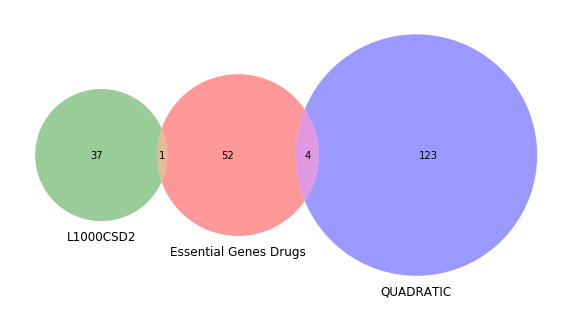

In [114]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn3, venn3_circles
plt.figure(figsize = (10,10))

venn3([ set(sko_drugs),set(l1k_drugs_list), set(quad_drugs_list)], ('Essential Genes Drugs', 'L1000CSD2', 'QUADRATIC'))
plt.show()

In [118]:
#l1k_drugs_list

In [119]:
#sko_drugs

In [120]:
#quad_drugs_list

#### Find shared genes between SKO and bait proteomic genes:
https://www.mcponline.org/content/mcprot/early/2020/06/26/mcp.RA120.002164.full.pdf

In [95]:
bait_genes = pd.read_excel('supplementary/161399_2_supp_555132_qczxzc.xlsx',sheet_name='Potential interactors')
bait_genes = bait_genes.loc[bait_genes['Differentially expressed'] ==1.0,:]

In [96]:
bait_genes.head()

,PreyGene,Bait,Log2 iBAQ ratio,Unnamed: 3,Unnamed: 4,Unnamed: 5,Differentially expressed
1,HMOX1,orf3a,0.720401,1.30739,-0.720401,-3.46426,1.0
2,GOLGA3,nsp13,0.405574,-4.05613,-0.405574,0.444674,1.0
3,NIN,nsp13,2.24981,-2.24981,NaN,NaN,1.0
4,LARP1,(N) NCAP,0.115846,-4.37305,0.0891611,-0.0891611,1.0
5,MFGE8,orf8,0.0119945,-2.66521,1.71124,-0.0119945,1.0


In [97]:
bait_genes_list = bait_genes.PreyGene.tolist()#[1:]

In [98]:
# Shared genes
[x for x in sko_genes if x in bait_genes_list]

[]

In [99]:
# Pathway analysis of bait genes
import gseapy as gp
gene_sets=['KEGG_2019_Human']
enr = gp.enrichr(gene_list=bait_genes_list,#dko_all_genes,
                 description='Proteomics',
                 gene_sets=gene_sets,
                 outdir='enrichment/Proteomics',
                 cutoff=0.1 # test dataset, use lower value from range(0,1)
                )
enrich = enr.results
enrich = enrich.loc[enrich['P-value']<0.1,:]
enrich = enrich.loc[:,['Term','Genes','P-value','Overlap']]

2020-07-17 07:37:02,692 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.1


In [100]:
enrich

,Term,Genes,P-value,Overlap
0,Protein processing in endoplasmic reticulum,WFS1;NGLY1;UGGT2,0.006070,3/165
1,Thyroid hormone synthesis,GPX1;PRKACA,0.012065,2/74
2,Lysosome,PPT1;GLA,0.031270,2/123
3,Thiamine metabolism,THTPA,0.033235,1/15
4,Dopaminergic synapse,COMT;PRKACA,0.035091,2/131
5,Folate biosynthesis,GGH,0.056918,1/26
6,Fatty acid elongation,PPT1,0.059043,1/27
7,Galactose metabolism,GLA,0.067495,1/31
8,Prion diseases,PRKACA,0.075873,1/35
9,Tyrosine metabolism,COMT,0.077956,1/36


In [101]:
enrich.to_csv('enrichment/Proteomic_Gene_Enrichment.csv')

In [102]:
# Genes in the proteomic study and FerrDB
[x for x in bait_genes_list if x in ferrdb_genes]

['HMOX1']

In [103]:
# Genes in the proteomic study and CRISPR study
[x for x in bait_genes_list if x in crispr_genes.tolist()]

[]

In [104]:
len(crispr_genes)

50

In [105]:
len(bait_genes_list)

45

In [111]:
# Read the mtabolomics study MS normalized concentration for Pathway analysis by MetaboAnalyst
df = pd.read_excel('supplementary/140327-INS-CMED-RV-3_sd_428554.xlsx',sheet_name='Targeted Metabolomics')

In [112]:
df.head()

,Run,Original,Group,compound,Interleukin-6,L-alanine,L-arginine,L-asparagine,L-aspartate,L-cysteine,...,Riboflavin.1,N-Amidino-L-aspartate,N-Acyl-D-glutamate,N-Acetylmethionine,10-Hydroxydecanoic acid,Protein 5-hydroxylysine,N-Carbamyl-L-glutamate,2-Oxo-7-methylthioheptanoic acid,L-Homocitrulline,pipecolate.1
0,34,C1,01-Control,r20,5.0,19990670,9228337,998939.0,993278.8,80237.79,...,212816.5,52466.52,18703.68,14405.000,210344.5,165523.50,61687.91,1638343,31381.90,144788.30
1,35,C2,01-Control,r31,5.0,15567320,10348230,777486.2,761960.3,50180.50,...,109703.3,97625.52,22621.36,7711.764,189087.3,88577.84,68550.58,1550553,38350.21,203219.30
2,36,C3,01-Control,r3,5.0,16652310,11846780,787974.5,561401.0,25568.12,...,166677.7,97795.18,35551.75,6847.793,174462.6,110938.00,93611.25,1826665,83338.43,65562.34
3,37,C4,01-Control,r46,5.0,20382350,4484620,1133116.0,916786.1,13659.42,...,357974.1,80159.66,37436.46,12502.720,223119.9,307523.70,80822.35,2247793,47179.25,199683.60
4,38,C5,01-Control,r41,5.0,25380030,8740999,1182191.0,838449.2,14252.32,...,317585.3,70775.38,31819.13,11435.040,233896.2,332864.20,86427.82,2511426,38014.95,120537.90


In [113]:
df = df.drop(columns=['Run','compound','Group'])

In [114]:
df.Original = '"'  + df.Original +'"'

In [115]:
df.head()

,Original,Interleukin-6,L-alanine,L-arginine,L-asparagine,L-aspartate,L-cysteine,L-glutamate,L-glutamine,glycine,...,Riboflavin.1,N-Amidino-L-aspartate,N-Acyl-D-glutamate,N-Acetylmethionine,10-Hydroxydecanoic acid,Protein 5-hydroxylysine,N-Carbamyl-L-glutamate,2-Oxo-7-methylthioheptanoic acid,L-Homocitrulline,pipecolate.1
0,"""C1""",5.0,19990670,9228337,998939.0,993278.8,80237.79,6982712,16747450,2575233,...,212816.5,52466.52,18703.68,14405.000,210344.5,165523.50,61687.91,1638343,31381.90,144788.30
1,"""C2""",5.0,15567320,10348230,777486.2,761960.3,50180.50,4942592,18337380,2204026,...,109703.3,97625.52,22621.36,7711.764,189087.3,88577.84,68550.58,1550553,38350.21,203219.30
2,"""C3""",5.0,16652310,11846780,787974.5,561401.0,25568.12,3347806,13889700,2238460,...,166677.7,97795.18,35551.75,6847.793,174462.6,110938.00,93611.25,1826665,83338.43,65562.34
3,"""C4""",5.0,20382350,4484620,1133116.0,916786.1,13659.42,8906316,20466620,2428056,...,357974.1,80159.66,37436.46,12502.720,223119.9,307523.70,80822.35,2247793,47179.25,199683.60
4,"""C5""",5.0,25380030,8740999,1182191.0,838449.2,14252.32,7517548,20190410,2643947,...,317585.3,70775.38,31819.13,11435.040,233896.2,332864.20,86427.82,2511426,38014.95,120537.90


In [120]:
columns = df.columns
columns = [x.split('/')[0] for x in columns]
#columns = [x.replace('2','3-Phospho-D-glycerate') for x in columns if x  =='2' else pass]
df.columns = columns

In [121]:
import csv

In [122]:
df.to_csv('supplementary/Metabolomics_Absolute_Quant.csv',sep=',',index=False,quoting=csv.QUOTE_NONNUMERIC)

In [14]:
!head supplementary/Metabolomics_Absolute_Quant.csv

"Original","Interleukin-6","L-alanine","L-arginine","L-asparagine","L-aspartate","L-cysteine","L-glutamate","L-glutamine","glycine","L-histidine","L-leucine","L-lysine","L-methionine","L-phenylalanine","L-proline","L-serine","L-threonine","L-tryptophan","L-tyrosine","L-valine","L-cystine","dAMP","Adenosine","Guanosine","Guanine","CTP","Cytidine","Cytosine","Thymidine","Thymine","Uracil","IMP","Inosine","Hypoxanthine","Xanthine","Allantoate","(S)(+)-Allantoin","5-Hydroxyisourate","Urate","5-6-Dihydrothymine","Pyridoxal","4-Pyridoxate","Pyridoxamine 5'-phosphate","Nicotinamide","Nicotinic acid","Phosphate","Diphosphate","D-Glucose","D-Hexose-phosphate","D-Fructose 1-6-bisphosphate","D-Glyceraldehyde 3-phosphate/Glycerone phosphate","2/3-Phospho-D-glycerate","Phosphoenolpyruvate","Pyruvate","Lactate","Maltose/Sucrose","Maltotriose","Mannitol/Sorbitol","D-Ribose","D-Rhamnose","D-Arabitol/Xylitol/Ribitol","Citrate","2-Oxoglutarate","2-Oxoglutaramate","Succinate","Fumarate","Malate","2-Hydro

In [ ]:
## Integrative Analysis of CRISPR Study, Proteomics & Essentiall Genes

In [ ]:
# Read Metabolomics study pathways

In [168]:
metabolomics_path_df = pd.read_csv('supplementary/MetaboAnalyst_Pathway_Analysis_Download/pathway_results.csv')

In [169]:
metabolomics_pathways = metabolomics_path_df['Unnamed: 0'].tolist()

In [157]:
bait_genes_list = bait_genes.PreyGene.str.replace('LOC103214541','HMGB1' ).tolist()

lists = [sko_genes,crispr_genes,bait_genes_list]
names = ['Essential_Genes','CRISPR','Proteomic']
genes_df  = pd.DataFrame(columns = ['List_Name','Gene'])
genes_df['List_Name'] = [0]*len(np.concatenate(lists))
k  =0
for i in range(len(lists)):
    genes_df.iloc[k:k+len(lists[i]),0] = [names[i]]*len(lists[i]) 
    genes_df.iloc[k:k+len(lists[i]),1] = lists[i]
    k += len(lists[i]) 

In [158]:
genes_df.tail()

,List_Name,Gene
110,Proteomic,SDF2
111,Proteomic,COMT
112,Proteomic,SLC44A2
113,Proteomic,NLRX1
114,Proteomic,PDE4DIP


In [159]:
genes_df.to_csv('supplementary/Proteomic_CRISPR_SKO_Genes.csv')

In [160]:
genes_df_unique = genes_df.groupby('List_Name').agg({'Gene': lambda x: list(x),'Gene': lambda x: '; '.join(list(x))
                                     })

In [161]:
genes_df_unique = genes_df_unique.loc[['Essential_Genes','CRISPR','Proteomic'],:]

In [162]:
glist = genes_df.Gene.tolist()
gene_sets='KEGG_2019_Human'

In [183]:
enrich.loc[enrich.Term.isin(shared_pathways),:]

,Term,Genes,P-value,Overlap,Essential_Genes,CRISPR,Proteomic
Term,,,,,,,
Glycerophospholipid metabolism,Glycerophospholipid metabolism,PTDSS1;CRLS1;PLD2,0.018468,3/97,0.030928,0.0,0.000000
Sphingolipid metabolism,Sphingolipid metabolism,SGMS1;GLA,0.029946,2/47,0.021277,0.0,0.021277
Pyrimidine metabolism,Pyrimidine metabolism,DTYMK;CMPK1,0.042611,2/57,0.035088,0.0,0.000000
Thiamine metabolism,Thiamine metabolism,THTPA,0.082891,1/15,0.000000,0.0,0.066667
Selenocompound metabolism,Selenocompound metabolism,CTH,0.093416,1/17,0.058824,0.0,0.000000
Folate biosynthesis,Folate biosynthesis,GGH,0.139314,1/26,0.000000,0.0,0.038462
Fatty acid elongation,Fatty acid elongation,PPT1,0.144269,1/27,0.000000,0.0,0.037037
Galactose metabolism,Galactose metabolism,GLA,0.163809,1/31,0.000000,0.0,0.032258
Tyrosine metabolism,Tyrosine metabolism,COMT,0.187614,1/36,0.000000,0.0,0.027778


In [192]:
idx.tolist()

[11, 15, 20, 31, 34, 45, 47, 49, 54]

In [194]:
colors = ['black']*(enrich.shape[0])
enrich2 = enrich.reset_index(drop=True)
idx = enrich2.loc[enrich2.Term.isin(shared_pathways),:].index.tolist()
for x in idx: 
    colors[x] = 'r'
for ytick, color in zip(ax.get_yticklabels(), colors):
    ytick.set_color(color)

In [200]:
shared_pathways = [x for x in metabolomics_pathways if x in enrich.Term]
shared_pathways

['Tyrosine metabolism',
 'Folate biosynthesis',
 'Thiamine metabolism',
 'Sphingolipid metabolism',
 'Fatty acid elongation',
 'Glycerophospholipid metabolism',
 'Galactose metabolism',
 'Selenocompound metabolism',
 'Pyrimidine metabolism']

2020-07-17 09:39:14,907 Connecting to Enrichr Server to get latest library names
2020-07-17 09:39:14,909 Analysis name: Proteomic_CRISPR_SKO_Genes, Enrichr Library: KEGG_2019_Human
2020-07-17 09:39:16,594 Save file of enrichment results: Job Id:6e658274cdede2886e871eab16dc75fd
2020-07-17 09:39:16,602 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2020-07-17 09:39:16,603 Done.



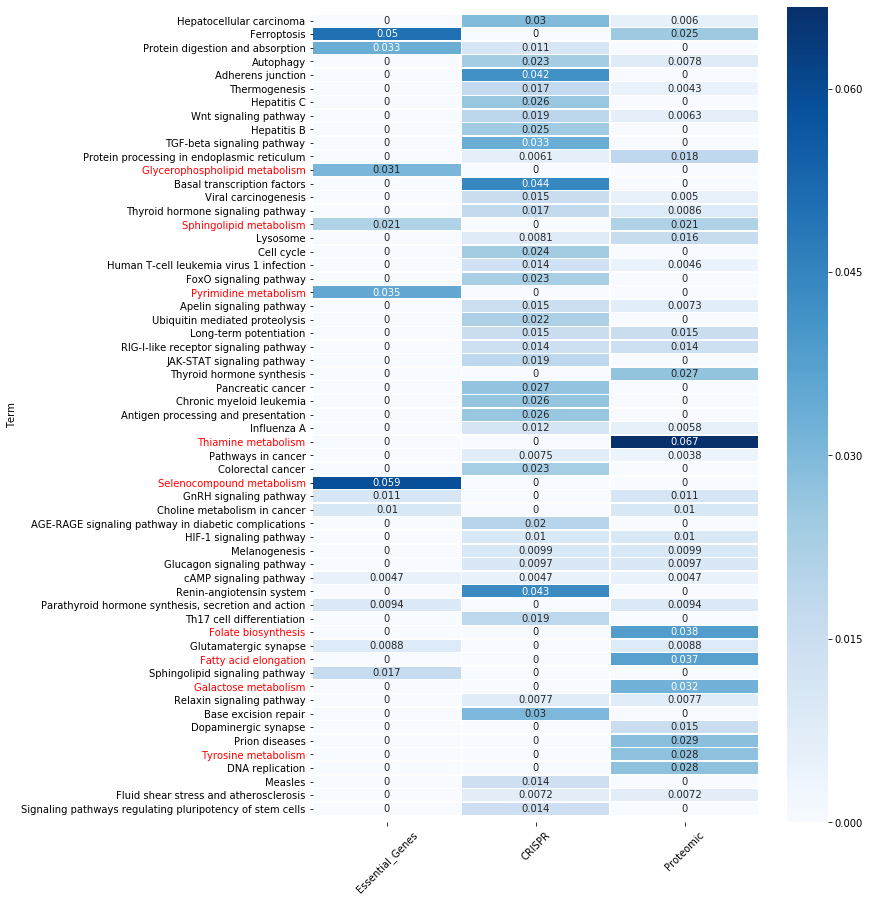

In [201]:
#Enrichment to both SKO 01 and 02
enr2 = gp.enrichr(gene_list=glist,
                  description='Proteomic_CRISPR_SKO_Genes',
                  gene_sets=gene_sets,
                  background='hsapiens_gene_ensembl', # or the number of genes, e.g 20000
                  outdir='Enrichment/Proteomic_CRISPR_SKO_Genes_Enrichment',
                  cutoff=0.05, # only used for testing.
                  verbose=True)
enrich = enr2.results
enrich = enrich.loc[:,['Term','Genes','P-value','Overlap']]
enrich = enrich.loc[enrich['P-value']<0.2,:]

enrich_coverage_all = Calculate_Enrichment_Coverage(enrich,genes_df_unique,'Gene')
plt.figure(figsize = (10,15))
ax = sns.heatmap(enrich_coverage_all.iloc[:,4:], annot=True, linewidths=0.5,cmap='Blues', yticklabels=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# add Color to pathways name based on shared with the Metabolomic Study
colors = ['black']*(enrich.shape[0])
enrich2 = enrich.reset_index(drop=True)
idx = enrich2.loc[enrich2.Term.isin(shared_pathways),:].index.tolist()
for x in idx: 
    colors[x] = 'r'
for ytick, color in zip(ax.get_yticklabels(), colors):
    ytick.set_color(color)


In [172]:
shared_pathways

['Tyrosine metabolism',
 'Folate biosynthesis',
 'Thiamine metabolism',
 'Sphingolipid metabolism',
 'Fatty acid elongation',
 'Glycerophospholipid metabolism',
 'Galactose metabolism',
 'Selenocompound metabolism',
 'Pyrimidine metabolism']

In [174]:
enrich_coverage_all.iloc[:,4:].loc[shared_pathways]

,Essential_Genes,CRISPR,Proteomic
Term,,,
Tyrosine metabolism,0.000000,0.0,0.027778
Folate biosynthesis,0.000000,0.0,0.038462
Thiamine metabolism,0.000000,0.0,0.066667
Sphingolipid metabolism,0.021277,0.0,0.021277
Fatty acid elongation,0.000000,0.0,0.037037
Glycerophospholipid metabolism,0.030928,0.0,0.000000
Galactose metabolism,0.000000,0.0,0.032258
Selenocompound metabolism,0.058824,0.0,0.000000
Pyrimidine metabolism,0.035088,0.0,0.000000


In [ ]:
plt.figure(figsize = (10,20))
ax = sns.heatmap(enrich_coverage_all.iloc[:,4:], annot=True, linewidths=0.5,cmap='Blues', yticklabels=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [170]:
enrich

,Term,Genes,P-value,Overlap,Essential_Genes,CRISPR,Proteomic
Term,,,,,,,
Hepatocellular carcinoma,Hepatocellular carcinoma,SMARCE1;SMAD4;SMAD3;HMOX1;ARID1A;SMARCA4,0.000425,6/168,0.000000,0.029762,0.005952
Ferroptosis,Ferroptosis,HMOX1;SLC3A2;SLC7A11,0.001567,3/40,0.050000,0.000000,0.025000
Protein digestion and absorption,Protein digestion and absorption,ACE2;SLC7A9;SLC3A1;SLC3A2,0.001812,4/90,0.033333,0.011111,0.000000
Autophagy,Autophagy,CTSL;EIF2AK4;HMGB1;PRKACA,0.006406,4/128,0.000000,0.023438,0.007812
Adherens junction,Adherens junction,CREBBP;SMAD4;SMAD3,0.008282,3/72,0.000000,0.041667,0.000000
Thermogenesis,Thermogenesis,SMARCE1;KDM1A;PRKACA;ARID1A;SMARCA4,0.010823,5/231,0.000000,0.017316,0.004329
Hepatitis C,Hepatitis C,TRAF3;PSME3;EIF2AK4;PIAS1,0.012348,4/155,0.000000,0.025806,0.000000
Wnt signaling pathway,Wnt signaling pathway,CREBBP;SMAD4;SMAD3;PRKACA,0.013170,4/158,0.000000,0.018987,0.006329
Hepatitis B,Hepatitis B,CREBBP;SMAD4;SMAD3;TRAF3,0.014615,4/163,0.000000,0.024540,0.000000


In [23]:
bait_genes = pd.read_excel('supplementary/161399_2_supp_555133_qc3x3c.xlsx',sheet_name='Annotated expression changes')

In [24]:
bait_genes.iloc[:,[2,34,35,36]]

,Gene names,T-test_3 MOI vs 0.1 MOI (Vero E6),Unnamed: 35,Unnamed: 36
0,NaN,"Significant (S0=0.03, 5% FDR)",p-value,log2 ratio
1,NFS1,NaN,0.599039,-0.0448996
2,GLRX3,True,1.33655,-0.398333
3,MTHFD1,NaN,0.283782,0.0202001
4,ALDH1L2,NaN,0.618703,-0.325034
...,...,...,...,...
7360,NaN,NaN,0.93261,-0.553699
7361,NaN,True,2.20556,0.251233
7362,NaN,True,2.0057,0.201001
7363,NaN,NaN,0.0134639,0.00133387


In [44]:
bait_genes.iloc[:,[2,31,32,33]]

,Gene names,T-test_3 MOI vs Mock (Vero E6),Unnamed: 32,Unnamed: 33
0,NaN,"Significant (S0=0.2, 5% FDR)",p-value,log2 ratio
1,NFS1,NaN,0.400957,-0.0484002
2,GLRX3,NaN,0.0102243,-0.00666682
3,MTHFD1,NaN,0.749621,0.0480671
4,ALDH1L2,NaN,0.0473026,-0.0474339
...,...,...,...,...
7360,NaN,NaN,0.0991551,-0.105967
7361,NaN,NaN,0.895263,0.167267
7362,NaN,NaN,0.51791,0.0666008
7363,NaN,NaN,1.059,-0.0980663


In [74]:
bait_genes_moi = bait_genes.iloc[:,[2,31,32,33]]
bait_genes_moi.columns = ['Gene names','Significant','p-value','log2 ratio']
bait_genes_moi= bait_genes_moi.dropna()
bait_genes_moi['p-value'] = bait_genes_moi['p-value'].astype('float')
bait_genes_high_moi = bait_genes_moi.loc[bait_genes_moi.Significant==True,'Gene names'].dropna().values

#bait_genes_high_moi = bait_genes_moi.loc[np.logical_and(bait_genes_moi.Significant==True,bait_genes_moi['log2 ratio']<0),'Gene names'].dropna().values
#bait_genes_low_moi = bait_genes_moi.loc[np.logical_and(bait_genes_moi.Significant==True,bait_genes_moi['log2 ratio']>=0),'Gene names'].dropna().values

In [77]:
bait_genes_moi = bait_genes.iloc[:,[2,28,29,30]]
bait_genes_moi.columns = ['Gene names','Significant','p-value','log2 ratio']
bait_genes_moi= bait_genes_moi.dropna()
bait_genes_moi['p-value'] = bait_genes_moi['p-value'].astype('float')
bait_genes_low_moi = bait_genes_moi.loc[bait_genes_moi.Significant==True,'Gene names'].dropna().values

In [60]:
#bait_genes_moi.head(10)

In [75]:
len(bait_genes_high_moi)

56

In [78]:
len(bait_genes_low_moi)

1

In [79]:
bait_genes_low_moi

array(['CHSY1'], dtype=object)